In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# How long does it take to compute graphlets?

- Tested by computing graphlets for each protein in the test set

In [7]:
rosetta_times = pd.read_table("rosetta_0p8_timing.tsv")
dmpfold_times = pd.read_table("dmpfold_0p8_timing.tsv")
cath_times    = pd.read_table("cath_repr_timing.tsv")

cath_times['dataset'] = 'cath'
rosetta_times['dataset'] = 'rosetta_0p8'
dmpfold_times['dataset'] = 'dmpfold_0p8'

times = pd.concat([cath_times, rosetta_times, dmpfold_times])
times['elapsed'] = pd.to_timedelta(times['elapsed'])

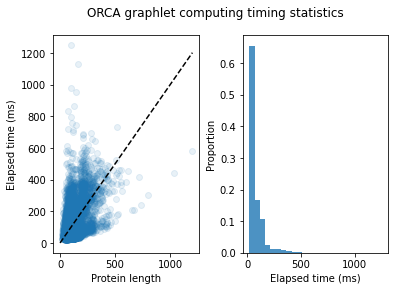

In [101]:
fig, (ax2, ax1) = plt.subplots(1, 2)
fig.suptitle("ORCA graphlet computing timing statistics")
times.elapsed.astype('timedelta64[ms]').plot.hist(bins=25, ax=ax1, 
                                                  alpha=0.8, 
                                                  weights=np.ones(len(times)) / len(times))

ax1.set_xlabel("Elapsed time (ms)")
ax1.set_ylabel("Proportion")

ax2.set_ylabel("Elapsed time (ms)")
ax2.set_xlabel("Protein length")
ax2.scatter(times.length, times.elapsed.astype('timedelta64[ms]'), alpha=0.1)
ax2.plot([0, times.length.max()], [0, times.length.max()], linestyle='--', color='k')
plt.subplots_adjust(wspace=0.3)

plt.savefig("figs/orca_timing.png")
plt.show()

# What does the graphlet representation space look like?

In [51]:
cath_reprs    = np.load("cath_repr_all_graphlets.npz", allow_pickle=True)
rosetta_reprs = np.load("rosetta_0p8_all_graphlets.npz", allow_pickle=True)
dmpfold_reprs = np.load("dmpfold_0p8_all_graphlets.npz", allow_pickle=True)

In [55]:
print("TSNE projecting to 2-space...")
cath_tsne = TSNE(n_components=2).fit_transform(cath_reprs['normed_counts'])
print("cath done")
rosetta_tsne = TSNE(n_components=2).fit_transform(rosetta_reprs['normed_counts'])
print("rosetta done")
dmpfold_tsne = TSNE(n_components=2).fit_transform(dmpfold_reprs['normed_counts'])
print("dmpfold done")

TSNE projecting to 2-space...
cath done
rosetta done
dmpfold done


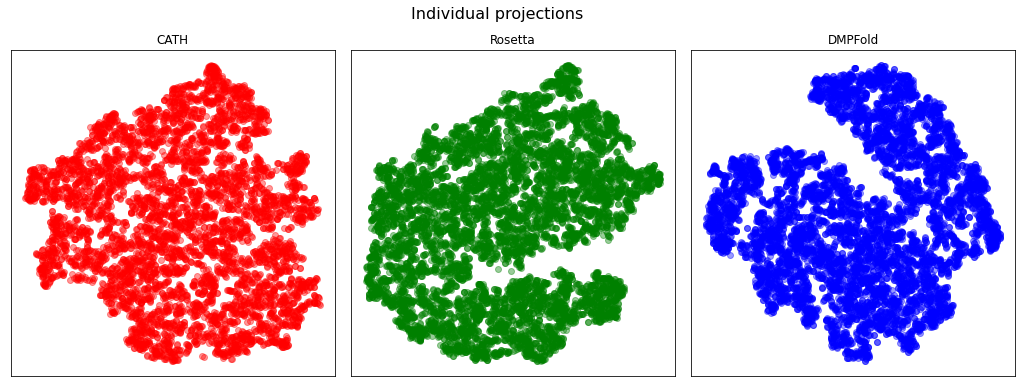

In [92]:
def scatter(data, ax, title=None, xlabel=None, ylabel=None, **kwargs):
    x = data[:, 0]
    y = data[:, 1]
    
    if title:
        ax.set_title(title)
    if xlabel:
        ax.set_xlabel(xlabel)
    if ylabel:
        ax.set_ylabel(ylabel)
    
    ax.scatter(x, y, **kwargs)

fig, axarr = plt.subplots(1, 3, figsize=(18, 6))

fig.suptitle("Individual projections", fontsize=16)
for (ax, tsne, title, c) in zip(axarr, 
                                 (cath_tsne, rosetta_tsne, dmpfold_tsne), 
                                 ("CATH", "Rosetta", "DMPFold"),
                                 "rgb"):
    scatter(tsne, ax, title=title, alpha=0.4, color=c)
    ax.set_xticks([])
    ax.set_yticks([])

plt.subplots_adjust(wspace=0.05)
plt.savefig("figs/individual_tsne.png", bbox_inches='tight')
plt.show()

In [76]:
all_samples = np.concatenate([npz['normed_counts'] for npz in (cath_reprs, rosetta_reprs, dmpfold_reprs)])
combined_tsne = TSNE(n_components=2).fit_transform(all_samples)

In [82]:
shapes = [x.shape[0] for x in (cath_tsne, rosetta_tsne, dmpfold_tsne)]
intervals = []
for i, n in enumerate(shapes):
    interval = (0 if not i else intervals[i - 1][1], n if not i else intervals[i-1][1] + n)
    intervals.append(interval)
    

[(0, 6119), (6119, 14761), (14761, 23403)]

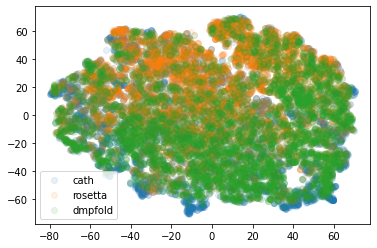

In [88]:
fig, ax = plt.subplots(1)

for (start, stop), name in zip(intervals, ("cath", "rosetta", "dmpfold")):
    scatter(combined_tsne[start:stop], ax, label=name, alpha=0.1)
ax.legend()
plt.show()